In [60]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)
import random
import sys
import tensorflow as tf
import transformers
from transformers import DistilBertTokenizerFast, TFDistilBertModel, logging
logging.set_verbosity_error()
from sklearn.metrics import classification_report
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

K = tf.keras

print('python version: ', sys.version)
print('tf version: ', tf.__version__)
print('transformers version:', transformers.__version__)

python version:  3.10.14 (main, May  6 2024, 14:47:20) [Clang 14.0.6 ]
tf version:  2.12.0
transformers version: 4.27.3


In [61]:
stance_dataset = 'atheism'

df_train = pd.read_csv(f'./archive/stance_{stance_dataset}_train.csv')
df_test = pd.read_csv(f'./archive/stance_{stance_dataset}_test.csv')
df_val = pd.read_csv(f'./archive/stance_{stance_dataset}_validation.csv')
print(df_train.head())

                                                text  label
0  @user Bless Almighty God, Almighty Holy Spirit...      1
1  Take away hatred from some people, and you hav...      1
2  I took my troubles to the Lord: I cried out to...      1
3  You can't think by yourself about life and bel...      2
4  RT @user Humanist love to everyone at #100AEUA...      0


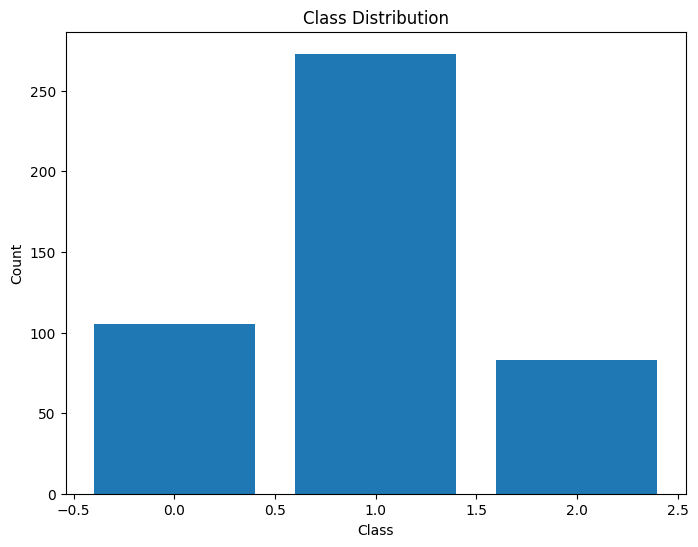

{1: 0.5921908893709328, 2: 0.18004338394793926, 0: 0.227765726681128}

In [62]:
class_counts = df_train['label'].value_counts()

plt.figure(figsize=(8, 6))
plt.bar(class_counts.index, class_counts)
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Distribution')
plt.show()

class_weights = {class_label: len(df_train[df_train['label'] == class_label]) / len(df_train) for class_label in df_train['label'].unique()}
class_weights

In [63]:
BERT_MODEL_NAME = 'distilbert-base-uncased'
MAX_SEQUENCE_LENGTH = 512
NUM_BASE_MODEL_OUTPUT = 768
BATCH_SIZE = 4
NUM_LABELS = df_train['label'].nunique()

In [64]:
%env TOKENIZERS_PARALLELISM=false

tokenizer = DistilBertTokenizerFast.from_pretrained(BERT_MODEL_NAME, resume_download=None)
tokenize = lambda text: tokenizer(text, truncation=True, padding='max_length', max_length=512, return_tensors="tf")

def prepare_dataset(df, shuffle=False):
  t = tokenize(df['text'].tolist())
  print(f"input_ids: {t['input_ids'].shape}, attention_mask: {t['attention_mask'].shape}, labels: {df['label'].shape}")
  dataset = tf.data.Dataset.from_tensor_slices((dict(t), df['label']))
  dataset = dataset.batch(BATCH_SIZE, drop_remainder=True).prefetch(1)
  if shuffle:
    dataset = dataset.shuffle(buffer_size=len(df_train), reshuffle_each_iteration=True)
  return dataset


train_dataset = prepare_dataset(df_train, shuffle=True)
test_dataset = prepare_dataset(df_test)
val_dataset = prepare_dataset(df_val)

env: TOKENIZERS_PARALLELISM=false
input_ids: (461, 512), attention_mask: (461, 512), labels: (461,)
input_ids: (220, 512), attention_mask: (220, 512), labels: (220,)
input_ids: (52, 512), attention_mask: (52, 512), labels: (52,)


In [65]:
input_ids = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype=tf.int32, name='input_ids')
attention_mask = tf.keras.layers.Input((MAX_SEQUENCE_LENGTH,), dtype=tf.int32, name='attention_mask')

base = TFDistilBertModel.from_pretrained(BERT_MODEL_NAME, num_labels=NUM_LABELS, resume_download=None)
for layer in base.layers[-2:]:  # Unfreeze the last layer
    layer.trainable = True

output = base([input_ids, attention_mask]).last_hidden_state[:, 0, :] # Output [CLS] Embedding
base_model = K.models.Model(inputs=[input_ids, attention_mask], outputs=output, name='bert-base-model')
base_model.summary()

Model: "bert-base-model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 512)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 512)]        0           []                               
                                                                                                  
 tf_distil_bert_model_10 (TFDis  TFBaseModelOutput(l  66362880   ['input_ids[0][0]',              
 tilBertModel)                  ast_hidden_state=(N               'attention_mask[0][0]']         
                                one, 512, 768),                                                   
                                 hidden_states=None                                 

In [66]:
output = K.layers.Dropout(rate=0.3)(output)
output = K.layers.Dense(units=NUM_BASE_MODEL_OUTPUT, kernel_initializer=K.initializers.GlorotUniform(), activation=None)(output)
output = K.layers.BatchNormalization()(output)
output = K.layers.Activation(K.activations.relu)(output)

output = K.layers.Dropout(rate=0.4)(output)
output = K.layers.Dense(units=NUM_BASE_MODEL_OUTPUT, kernel_initializer=K.initializers.GlorotUniform(), activation=None)(output)
output = K.layers.BatchNormalization()(output)
output = K.layers.Activation(K.activations.relu)(output)
output = K.layers.Dense(
    units=NUM_LABELS,
    kernel_initializer=K.initializers.GlorotUniform(),
    kernel_regularizer=K.regularizers.l2(l2=0.01),
    activation=K.activations.softmax
)(output)

model = K.models.Model(inputs=[input_ids, attention_mask], outputs=output, name='stance-model')
model.summary()

Model: "stance-model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 512)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 512)]        0           []                               
                                                                                                  
 tf_distil_bert_model_10 (TFDis  TFBaseModelOutput(l  66362880   ['input_ids[0][0]',              
 tilBertModel)                  ast_hidden_state=(N               'attention_mask[0][0]']         
                                one, 512, 768),                                                   
                                 hidden_states=None                                    

In [20]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy'],
)

history = model.fit(
    train_dataset,
    epochs=10,
    class_weight=class_weights,
    validation_data=val_dataset
)

Epoch 1/10
115/115 [==============================] - 47s 250ms/step - loss: 0.4424 - accuracy: 0.5043 - val_loss: 1.0899 - val_accuracy: 0.5577
Epoch 2/10
115/115 [==============================] - 28s 240ms/step - loss: 0.3524 - accuracy: 0.5826 - val_loss: 1.2578 - val_accuracy: 0.4808
Epoch 3/10
115/115 [==============================] - 27s 237ms/step - loss: 0.3154 - accuracy: 0.6196 - val_loss: 0.9190 - val_accuracy: 0.6154
Epoch 4/10
115/115 [==============================] - 28s 243ms/step - loss: 0.2730 - accuracy: 0.7000 - val_loss: 1.8423 - val_accuracy: 0.6154
Epoch 5/10
115/115 [==============================] - 27s 238ms/step - loss: 0.2521 - accuracy: 0.7196 - val_loss: 1.3067 - val_accuracy: 0.4615
Epoch 6/10
115/115 [==============================] - 28s 242ms/step - loss: 0.2292 - accuracy: 0.7370 - val_loss: 1.1285 - val_accuracy: 0.7115
Epoch 7/10
115/115 [==============================] - 28s 240ms/step - loss: 0.2196 - accuracy: 0.7630 - val_loss: 0.8338 - val_ac

In [22]:
model.evaluate(test_dataset)

55/55 [==============================] - 4s 80ms/step - loss: 1.3288 - accuracy: 0.7091


[1.3288100957870483, 0.7090908885002136]

In [23]:
y_pred = model.predict(val_dataset)
predicted_labels = np.argmax(y_pred, axis=-1)
print(predicted_labels)

print(classification_report(df_val['label'], predicted_labels, target_names=['0', '1', '2']))

13/13 [==============================] - 2s 80ms/step
[1 1 1 1 1 1 1 2 1 1 1 2 2 2 1 2 1 1 1 2 1 1 1 1 1 1 2 2 2 1 2 1 1 2 0 1 1
 1 2 1 1 1 2 1 1 1 1 2 1 2 1 1]
              precision    recall  f1-score   support

           0       1.00      0.08      0.15        12
           1       0.78      0.90      0.84        31
           2       0.40      0.67      0.50         9

    accuracy                           0.67        52
   macro avg       0.73      0.55      0.50        52
weighted avg       0.76      0.67      0.62        52



In [24]:
for idx in random.sample(range(len(df_val)), 10):
    sample_true_label = df_val.iloc[idx]['label']
    sample_text = df_val.iloc[idx]['text']
    t = tokenize(sample_text)

    sample_prediction = model.predict([t['input_ids'], t['attention_mask']], verbose=0)
    sample_predicted_label = np.argmax(sample_prediction, axis=-1)[0]

    print("Sample {}: Predicted class: {} | True class: {}".format(idx, sample_predicted_label, sample_true_label))

Sample 13: Predicted class: 2 | True class: 2
Sample 40: Predicted class: 1 | True class: 1
Sample 25: Predicted class: 1 | True class: 1
Sample 41: Predicted class: 1 | True class: 1
Sample 10: Predicted class: 1 | True class: 1
Sample 32: Predicted class: 1 | True class: 1
Sample 26: Predicted class: 2 | True class: 0
Sample 39: Predicted class: 1 | True class: 1
Sample 29: Predicted class: 1 | True class: 1
Sample 34: Predicted class: 0 | True class: 0
